# Detailed Analysis
This analysis is the further work based off the cleaned data in the EDA notebook.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [29]:
#Extract data from MsSQL server - accessed through a DSN connection
df = pd.read_csv('CSDA1050_CL_Cleaned.csv')
df.head(5)

,Unnamed: 0,area,bedrooms,datetime,price,url,latitude,longitude,outlier,ppbrm,ppsqft,title_txt,body_txt,title_cln,body_cln,title_snt,body_snt
0,14418,1300.0,3.0,2019-03-19 08:35:00,2550.0,NaN,43.676357,-79.293031,False,850.0,1.961538,NaN,NaN,NaN,NaN,NaN,NaN
1,14417,750.0,2.0,2019-03-19 08:38:00,2600.0,NaN,43.685689,-79.312877,False,1300.0,3.466667,NaN,NaN,NaN,NaN,NaN,NaN
2,14416,950.0,2.0,2019-03-19 08:40:00,2650.0,NaN,43.663550,-79.341209,False,1325.0,2.789474,NaN,NaN,NaN,NaN,NaN,NaN
3,14415,1000.0,2.0,2019-03-19 09:19:00,4978.0,NaN,43.659319,-79.385182,False,2489.0,4.978000,NaN,NaN,NaN,NaN,NaN,NaN
4,14414,NaN,2.0,2019-03-19 09:22:00,3250.0,NaN,43.646728,-79.391226,False,1625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Location Analysis

In [31]:
# set the filepath and load in a shapefile
fp = 'neighbourhoods_planning_areas_wgs84/NEIGHBORHOODS_WGS84.shp'

map_df = gpd.read_file(fp)
print(map_df.crs)
# map_df=map_df.to_crs({'init': 'epsg:2019'})

{'init': 'epsg:4326'}


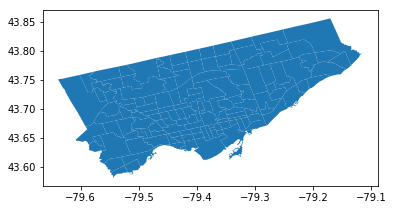

In [32]:
#Preview shapefile
map_df.plot()

In [33]:
#Format Lat/lon correctly for plotting
df['coordinates']=list(zip(df.longitude, df.latitude))
df['coordinates'] = df['coordinates'].apply(Point)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs,geometry='coordinates')
gdf.head()

,Unnamed: 0,area,bedrooms,datetime,price,url,latitude,longitude,outlier,ppbrm,ppsqft,title_txt,body_txt,title_cln,body_cln,title_snt,body_snt,coordinates
0,14418,1300.0,3.0,2019-03-19 08:35:00,2550.0,NaN,43.676357,-79.293031,False,850.0,1.961538,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.293031 43.676357)
1,14417,750.0,2.0,2019-03-19 08:38:00,2600.0,NaN,43.685689,-79.312877,False,1300.0,3.466667,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.312877 43.685689)
2,14416,950.0,2.0,2019-03-19 08:40:00,2650.0,NaN,43.663550,-79.341209,False,1325.0,2.789474,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.34120899999999 43.66355)
3,14415,1000.0,2.0,2019-03-19 09:19:00,4978.0,NaN,43.659319,-79.385182,False,2489.0,4.978000,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.385182 43.659319)
4,14414,NaN,2.0,2019-03-19 09:22:00,3250.0,NaN,43.646728,-79.391226,False,1625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.391226 43.646728)


In [34]:
#Calculate PPBRM and PPSQFT for each neighborhood of Toronto
#aggregate for all data, then filtered by bedroom count in listing

#Do analysis for bedroom counts all and 1-4
bedrooms = [1,2,3,4]

####Create GDF for all bedrooms count####
#sjoin to link data to neighborhoods
pointInPoly = gpd.sjoin(gdf, map_df, op='within') 

#aggregate overall data by neighborhood
tmp_ppbrm = pointInPoly.groupby('AREA_NAME')['ppbrm'].median()
tmp_ppsqft = pointInPoly.groupby('AREA_NAME')['ppsqft'].median()
tmp_bedrooms= pointInPoly.groupby('AREA_NAME')['bedrooms'].mean()

#join to shapefile
map_df_tmpa=map_df.merge(tmp_ppbrm, on='AREA_NAME')
map_df_tmpa=map_df_tmpa.merge(tmp_ppsqft, on='AREA_NAME')
map_df_tmpa=map_df_tmpa.merge(tmp_bedrooms, on='AREA_NAME')
map_df_tmpa['listbdrmcount'] = 'all'

#Store in map_df2
map_df2 = map_df_tmpa

#Repeate for all bedroom counts
for i in bedrooms:
    #sjoin to link data to neighborhoods
    pointInPoly = gpd.sjoin(gdf[gdf.bedrooms==i], map_df, op='within') 

    #aggregate overall data by neighborhood
    tmp_ppbrm = pointInPoly.groupby('AREA_NAME')['ppbrm'].median()
    tmp_ppsqft=pointInPoly.groupby('AREA_NAME')['ppsqft'].median()
    tmp_bedrooms=pointInPoly.groupby('AREA_NAME')['bedrooms'].mean()

    #join to shapefile
    map_df_tmp=map_df.merge(tmp_ppbrm, on='AREA_NAME')
    map_df_tmp=map_df_tmp.merge(tmp_ppsqft, on='AREA_NAME')
    map_df_tmp=map_df_tmp.merge(tmp_bedrooms, on='AREA_NAME')
    map_df_tmp['listbdrmcount'] = i
    
    #append to map_df2 
    map_df2=map_df2.append(map_df_tmp)


#fill NA with 0's
map_df2['ppbrm'].fillna(0, inplace=True)
map_df2['ppsqft'].fillna(0, inplace=True)
map_df2['bedrooms'].fillna(0, inplace=True)
map_df2.crs = map_df.crs

In [35]:
print(map_df2.crs)
map_df2 = gpd.GeoDataFrame(map_df2, crs=crs,geometry='geometry')
map_df2 = map_df2.to_crs({'init':'epsg:2019'})

{'init': 'epsg:4326'}


In [36]:
#Convert CRS to MTM Zone 10 (https://epsg.io/7991)
# map_df = map_df.to_crs(epsg=7991)
gdf['coordinates']=gdf['coordinates'].to_crs(epsg=2019)

In [37]:
map_df2.head()

,AREA_S_CD,AREA_NAME,geometry,ppbrm,ppsqft,bedrooms,listbdrmcount
0,097,Yonge-St.Clair (97),"POLYGON ((313572.832275433 4837693.591162446, ...",2000.00,2.800000,1.711111,all
1,027,York University Heights (27),"POLYGON ((304374.1999541915 4846441.25135292, ...",1475.00,3.993056,1.142857,all
2,038,Lansing-Westgate (38),"POLYGON ((309632.5212703118 4846630.090700979,...",1491.25,3.071184,1.852941,all
3,031,Yorkdale-Glen Park (31),"POLYGON ((309660.95786051 4840414.596033789, 3...",1800.00,2.923077,1.510638,all
4,016,Stonegate-Queensway (16),"POLYGON ((305395.276477816 4833950.152376727, ...",1750.00,1.807692,1.460000,all


In [38]:
#Rotate map to be better visually represented
map_df2['geometry']=map_df2['geometry'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
gdf['coordinates']=gdf['coordinates'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
map_df2.head()

,AREA_S_CD,AREA_NAME,geometry,ppbrm,ppsqft,bedrooms,listbdrmcount
0,097,Yonge-St.Clair (97),"POLYGON ((312960.8640338166 4838211.633720009,...",2000.00,2.800000,1.711111,all
1,027,York University Heights (27),"POLYGON ((306721.736518882 4849266.482576586, ...",1475.00,3.993056,1.142857,all
2,038,Lansing-Westgate (38),"POLYGON ((311805.5054839805 4847909.686176075,...",1491.25,3.071184,1.852941,all
3,031,Yorkdale-Glen Park (31),"POLYGON ((310015.4647588888 4841957.465010825,...",1800.00,2.923077,1.510638,all
4,016,Stonegate-Queensway (16),"POLYGON ((304046.1529530964 4837022.651334584,...",1750.00,1.807692,1.460000,all


In [39]:
gdf['longitude'] = gdf.coordinates.x
gdf['latitude'] = gdf.coordinates.y

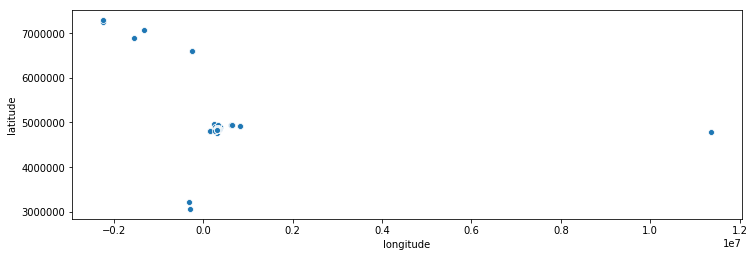

In [40]:
#plot all listings
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='gray',alpha = 0.4,)
sns.scatterplot("longitude", "latitude", data=gdf)
plt.show()


Clearly there are some wrongly labeled lat/long data points - anything outside of the cluster should be ignored

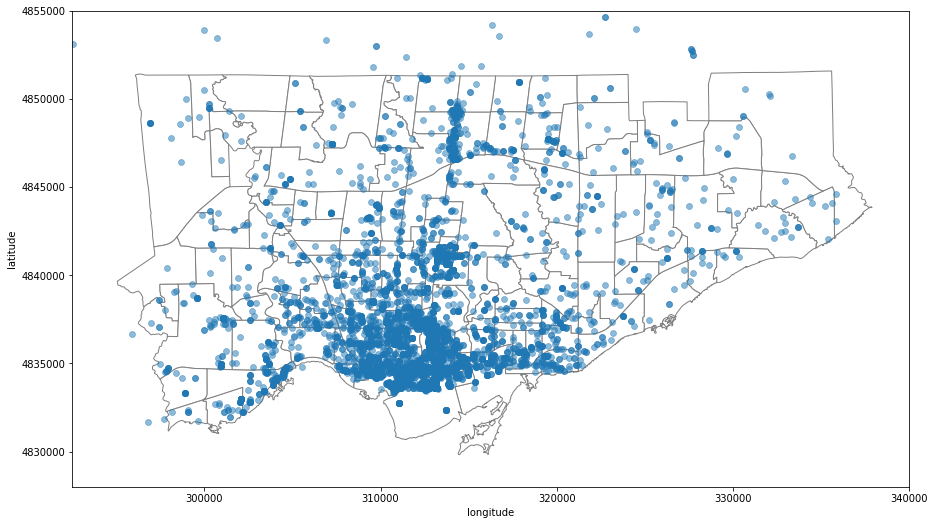

In [41]:
#plot all listings
xlim = (292500,340000)
ylim = (4828000,4855000)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey')
sns.scatterplot("longitude", "latitude", data=gdf,edgecolor = None ,alpha = 0.5)
plt.xlim(xlim)
plt.ylim(ylim)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.axis('off')
plt.show()

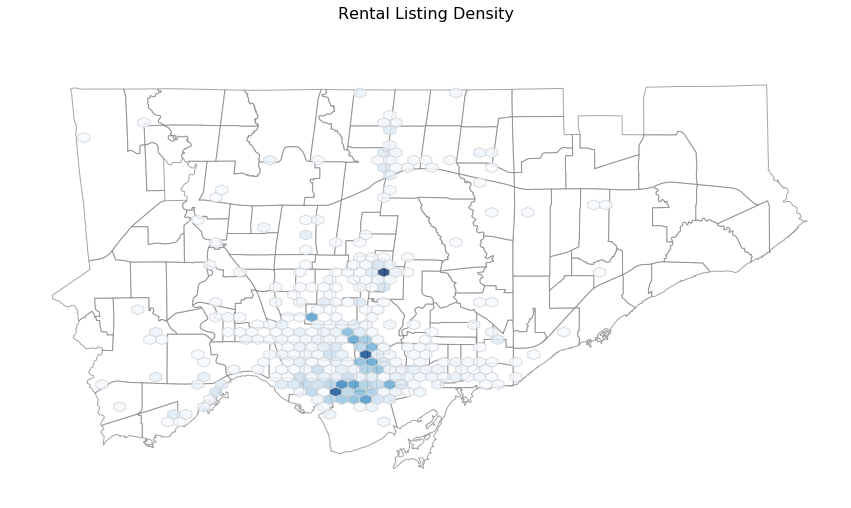

In [42]:
#this is quite busy, lets try it with a hex_bin plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey',alpha = 0.7,)
plt.hexbin(gdf.longitude, gdf.latitude, gridsize=(20000,5000),alpha=0.8,mincnt=5,edgecolors='lightgrey',cmap='Blues' )
plt.xlim(xlim)
plt.ylim(ylim)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.title('Rental Listing Density',fontsize=16)
plt.show()


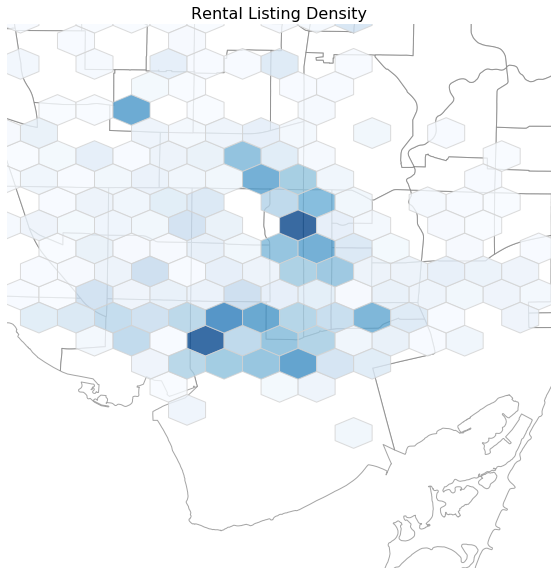

In [43]:
#Lets zoom into the downtown core
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey',alpha = 0.7,)
plt.hexbin(gdf.longitude, gdf.latitude, gridsize=(20000,5000),alpha = 0.8,mincnt=5,edgecolors='lightgrey',cmap='Blues')
plt.xlim(307500,317500)
plt.ylim(4830000,4840000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Rental Listing Density',fontsize=16)
ax.axis('off')
plt.show()

Highest prices seem to be in the downtown core, and up yonge street. Scarborough seems to have the lowest price per bedroom. This could be a function of bedroom count per listing as well. 

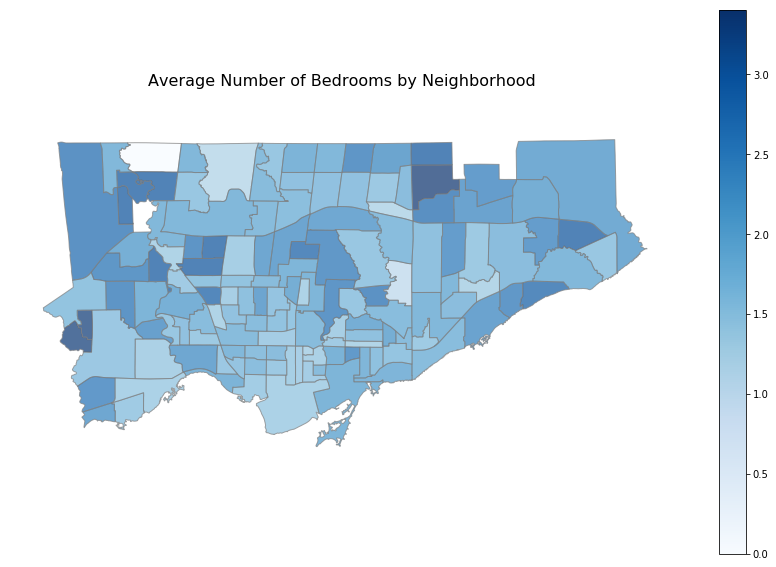

In [44]:
#Plot average number of bedrooms
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, column = 'bedrooms',edgecolor = 'grey',alpha = 0.7,cmap='Blues',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Average Number of Bedrooms by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

The highest prices were in the downtown core, and those areas look to generally have 1 bedroom units. From earlier in the analysis, 1 bedroom units were generally higher priced on a per/bedroom cost. 

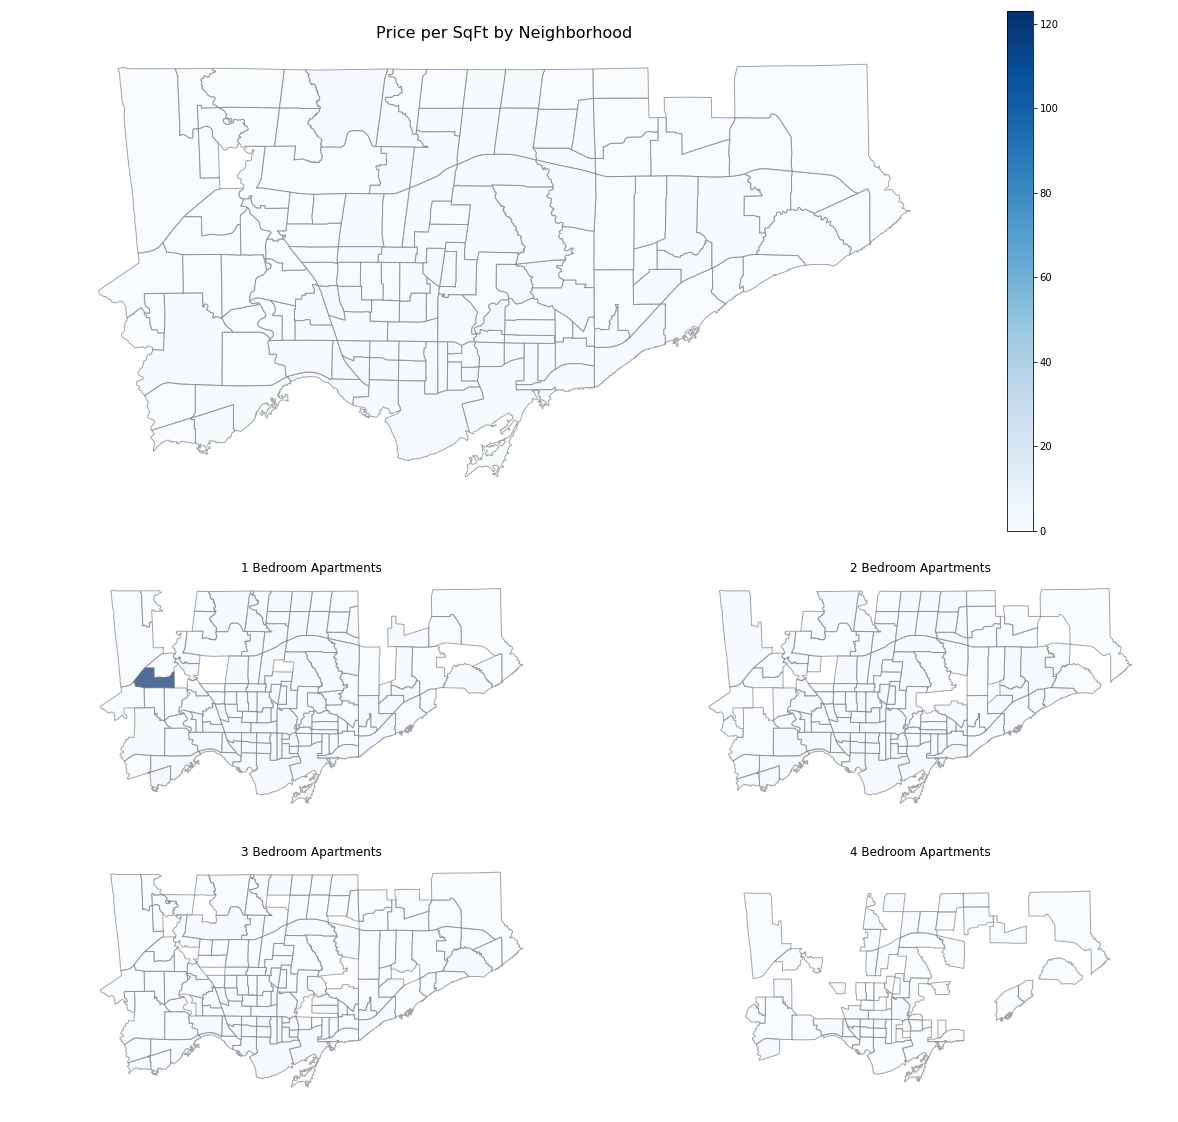

In [45]:
###Set up plot for Price Per Sqft###

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(20,20))

#establish consistent scale for all plots
scale_min = np.min(map_df2.ppsqft)
scale_max = np.max(map_df2.ppsqft)

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
map_df2[map_df2.listbdrmcount == 'all'].plot(ax = ax1, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues', legend = True)
plt.xlim(xlim)
plt.ylim(ylim)
ax1.axis('off')
ax1.set_title('Price per SqFt by Neighborhood',fontsize=16)

#filtered for 1-4 bedroom plots
map_df2[map_df2.listbdrmcount == 1].plot(ax = ax2, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax2.axis('off')
ax2.set_title('1 Bedroom Apartments',fontsize = 12)

map_df2[map_df2.listbdrmcount == 2].plot(ax = ax3, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax3.axis('off')
ax3.set_title('2 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 3].plot(ax = ax4, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax4.axis('off')
ax4.set_title('3 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 4].plot(ax = ax5, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax5.axis('off')
ax5.set_title('4 Bedroom Apartments',fontsize = 12)


plt.show()

There was a type in the EDA sheet with an area correction made on the wrong listing. This will be corrected when that runs through next (overnight 4/21)

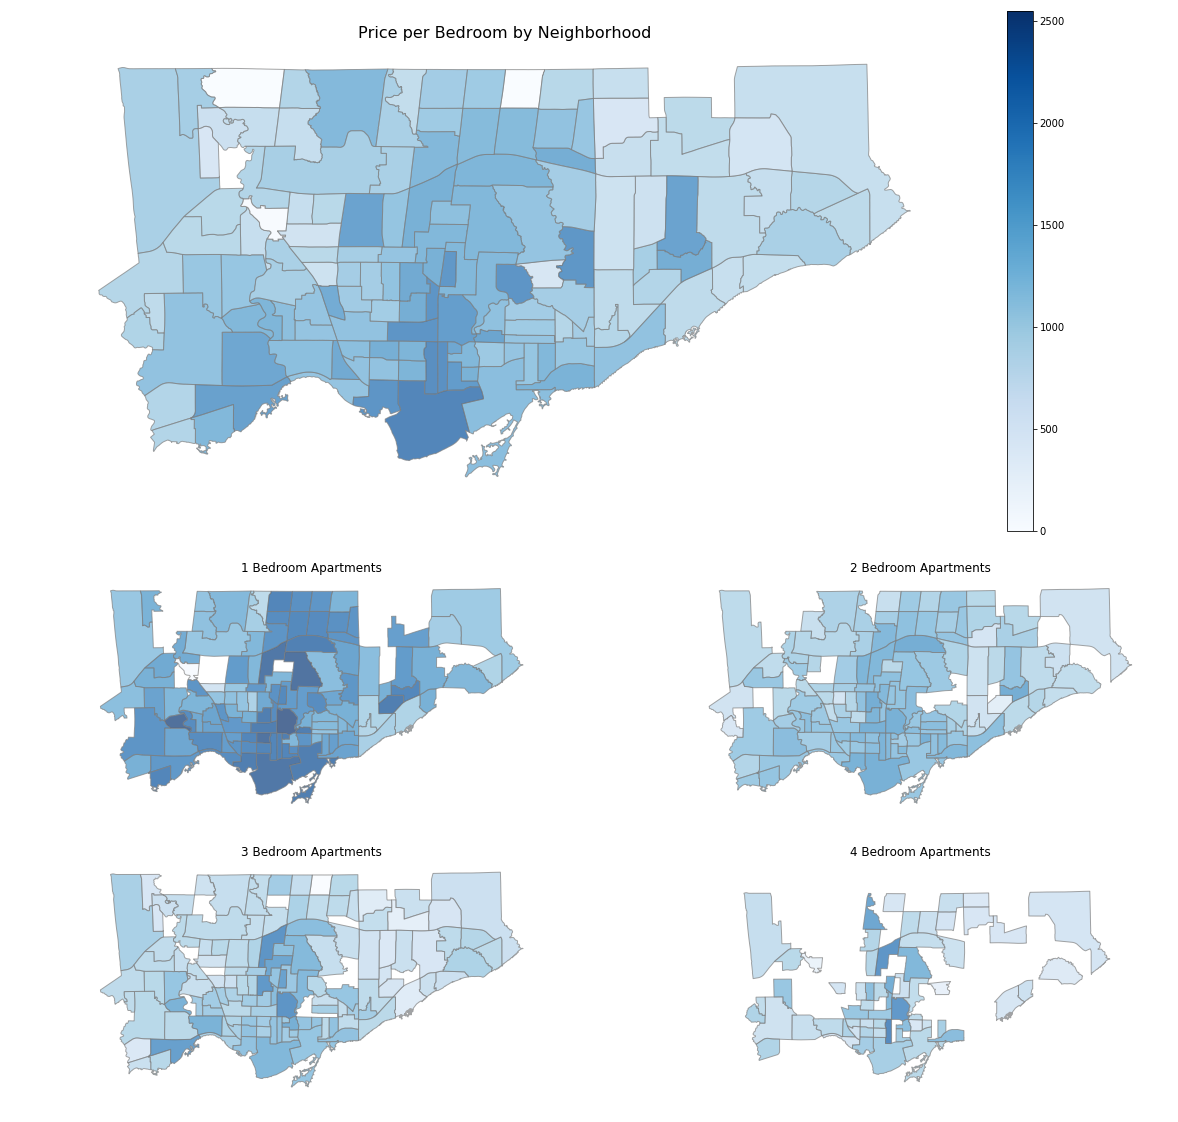

In [46]:
###Set up plot for Price per Bedroom###

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(20,20))

#establish consistent scale for all plots
scale_min = np.min(map_df2.ppbrm)
scale_max = np.max(map_df2.ppbrm)

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
map_df2[map_df2.listbdrmcount == 'all'].plot(ax = ax1, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues', legend = True)
plt.xlim(xlim)
plt.ylim(ylim)
ax1.axis('off')
ax1.set_title('Price per Bedroom by Neighborhood',fontsize=16)

#filtered for 1-4 bedroom plots
map_df2[map_df2.listbdrmcount == 1].plot(ax = ax2, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax2.axis('off')
ax2.set_title('1 Bedroom Apartments',fontsize = 12)

map_df2[map_df2.listbdrmcount == 2].plot(ax = ax3, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax3.axis('off')
ax3.set_title('2 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 3].plot(ax = ax4, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax4.axis('off')
ax4.set_title('3 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 4].plot(ax = ax5, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax5.axis('off')
ax5.set_title('4 Bedroom Apartments',fontsize = 12)


plt.show()